# Purpose

The purpose of this notebook is to house code and figures for aggregate properties the street/metro multiplex. These are properties that we can learn only from the multiplex and flows assigned on it, in contrast to properties (like path length distributions) that can be learned only via route-wise analysis. 

In [1]:
import matplotlib
matplotlib.use('Agg')
% matplotlib inline 

from metro import multiplex as mx
from metro import assignment
from metro import utility
from metro import ita
from metro import viz

import pandas as pd
import numpy as np
import cProfile
import time
import networkx as nx
import matplotlib.pyplot as plt # convenience for plotting
from matplotlib import pylab
pylab.rcParams['savefig.facecolor'] = 'black'
pylab.rcParams['savefig.dpi'] = 72 # should be ~300 for final figs

Read the multiplex

In [2]:
multi = mx.read_multi(nodes_file_name = '3_throughput/mx_flow_nodes.txt', 
                      edges_file_name = '3_throughput/mx_flow_edges.txt')

## Flowmaps as functions of $\beta$. 

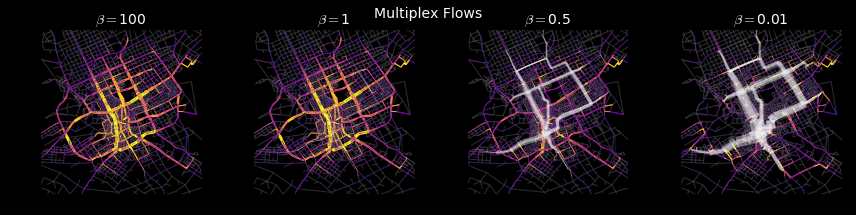

In [3]:
cmap = 'plasma'

center_point = (46.7167, 24.6333)
l = .2

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)

betas = [100, 1, .5, .01]

fig = plt.figure(dpi = 500, figsize = (3 * len(betas),3))

i = 0
for i in range(len(betas)):
    ax = fig.add_subplot(1, len(betas), i+1)
    plt.title(r'$\beta = $' + str(betas[i]), 
              color = 'w', 
              fontsize = 14)
    ax.set(xlim = xlim, ylim = ylim)
    viz.flow_plot(multi, 'flow_' + str(betas[i]), ax)
    
fig.set_facecolor("#000000")
fig.suptitle('Multiplex Flows', color = 'w', fontsize = 14)
plt.tight_layout()
plt.savefig('4_figs/flow_map.png')

## Aggregate flow through metro

In [4]:
import seaborn as sns
sns.set_style("white")
pylab.rcParams['savefig.facecolor'] = 'white'

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [5]:
betas = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1, .01]

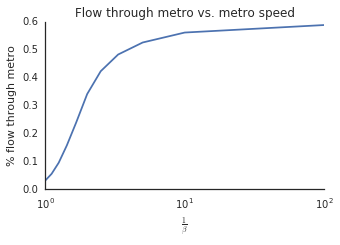

In [6]:
def metro_flow(beta): 
    flow = 'flow_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow, 'dist_km'])
    df['weighted_flow'] = df[flow] * df['dist_km']
    sums = df.groupby('layer').sum()['weighted_flow']
    metro, streets = (sums['metro'], sums['streets'])
    return 1.0 * metro / (metro + streets)

fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)

y = [metro_flow(beta) for beta in betas]
x = [1.0/beta for beta in betas]
ax.semilogx(x,y)
ax.set(ylim = (0, None), 
       xlabel = r'$\frac{1}{\beta}$', 
       ylabel = '% flow through metro',
       title = 'Flow through metro vs. metro speed')

sns.despine()
plt.savefig('4_figs/flow_thru_metro.png')


# Time spent, lost to congestion

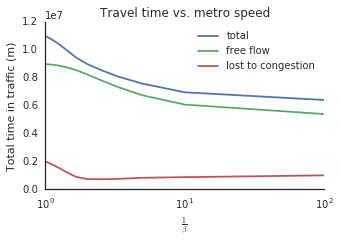

In [7]:
def time_lost(beta):
    flow = 'flow_' + str(beta)
    cong_time = 'congested_time_m_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow, 'capacity', 'free_flow_time_m', cong_time])
    df['time_lost'] = df[flow]* (df[cong_time] - df['free_flow_time_m'])
    df = df[df.layer == 'streets']
    return df.sum()['time_lost']

def time_free(beta):
    flow = 'flow_' + str(beta)
    cong_time = 'congested_time_m_' + str(beta)
    
    df = utility.edges_2_df(multi.G, ['layer', flow, 'capacity', 'free_flow_time_m', cong_time])
    df['time_free'] = df[flow] * df['free_flow_time_m']

    streets_part = df[df.layer == 'streets'].sum()['time_free']
    
    df['time_free'] = df[flow] * df[cong_time]
    metro_part = df[df.layer == 'metro'].sum()['time_free']
    return streets_part + metro_part

def time_spent(beta):
    flow = 'flow_' + str(beta)
    cong_time = 'congested_time_m_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow,  cong_time])
    df['time_spent'] = df[flow]*df[cong_time]
    return df.sum()['time_spent']

fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)
betas = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1, .01]
x = [1.0/beta for beta in betas]

labs = ['total', 'free flow', 'lost to congestion']
funs = [time_spent, time_free, time_lost]

for i in range(3):
    y = [funs[i](beta) for beta in betas]
    ax.semilogx(x,y, label = labs[i])

ax.set(ylim = (0, None), 
       xlabel = r'$\frac{1}{\beta}$', 
       ylabel = 'Total time in traffic (m)',
       title = 'Travel time vs. metro speed')

ax.legend(loc = 1)
sns.despine()
plt.savefig('4_figs/time_decomp.png')

## Total distance traveled

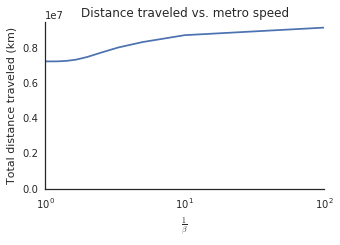

In [8]:
def distance_travelled(beta):
    flow = 'flow_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow, 'capacity', 'free_flow_time_m', 'dist_km'])
    df['distance_travelled'] = df[flow]*df.dist_km
    return df.sum()['distance_travelled']

x = [1.0/beta for beta in betas]
y = [distance_travelled(beta) for beta in betas]

fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)
ax.semilogx(x,y)

ax.set(ylim = (0, None), 
       xlabel = r'$\frac{1}{\beta}$', 
       ylabel = 'Total distance traveled (km)',
       title = 'Distance traveled vs. metro speed')
sns.despine()
plt.savefig('4_figs/distance_traveled.png')

## Betweenness distributions

/home/pchodrow/.local/lib/python2.7/site-packages/seaborn/categorical.py:2123: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


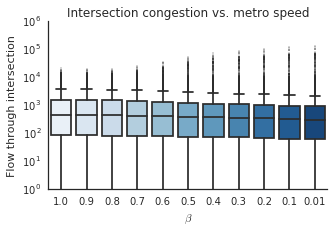

In [9]:
sns.set_palette(sns.color_palette("Blues", len(betas)))
G = multi.layers_as_subgraph(multi.get_layers())

def get_betweenness(beta):
    flow = 'flow_' + str(beta)
    return np.array([np.sum([G.edge[e[0]][e[1]][flow] 
                             for e in G.in_edges(n)]) 
                     for n in G.node])

df = pd.DataFrame({beta : get_betweenness(beta) for beta in betas})

fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)

flierprops = dict(marker='o', markersize=1)
sns.boxplot(df, order = np.array(betas[::]), ax = ax, flierprops = flierprops)

ax.set_yscale('log')
ax.set(xlabel = r'$\beta$', 
       ylabel = 'Flow through intersection',
       ylim = (1, None),
       title = 'Intersection congestion vs. metro speed')

sns.despine()
plt.savefig('4_figs/betweenness.png')